# Predicting 2021 NBA Playoffs Using Bradley Terry Model
John Zhang

The Bradley Terry model predicts the outcome of a competition between two players, where the coefficient for each player represents each players “ability”, which can be used to calculate the odds of one player beating another. 

I will be using data from the shortened 2020-2021 NBA regular season to develop a Bradley-Terry model that we can use to predict the outcome of the 2021 NBA playoffs.

<img src="https://c1.wallpaperflare.com/preview/1008/196/37/nba-basket-ball-hoop-dribbble.jpg" width="400">


First thing we need to do is install and load all required packages. Note that if you're running this on a local version of R you may not have these libraries installed, if so you'll need to install them.

In [ ]:
#Load Libraries and packages
install.packages('BradleyTerry2')
library(rvest)
library(lubridate)
library(dplyr)
library(reshape2)
library(data.table)
library(BradleyTerry2)

Now, in order to run a Bradley Terry model we need to organize the data to look something like this - where for each team, their wins and losses against every time is counted:
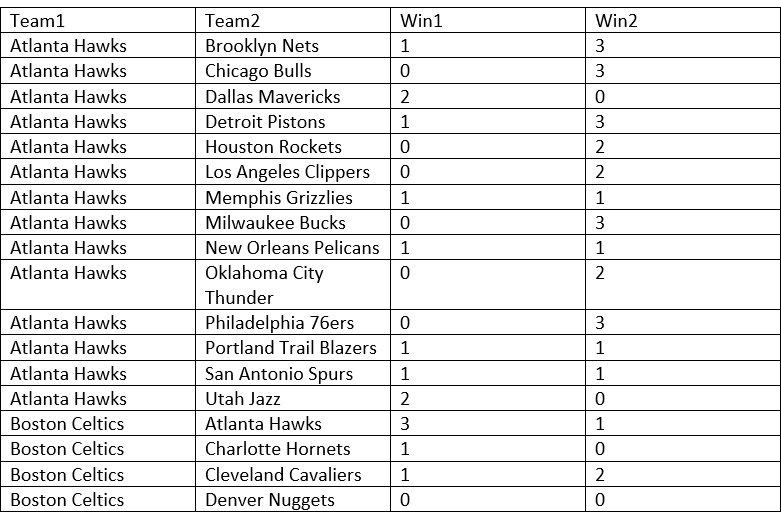

In order to this, we will be scraping data from Basketball-Reference (the greatest sports data site out there).

Let's begin by creating lists of Team ID's and names for all 30 NBA teams, which will be important in creating URL's to basketball-reference.com.

In [ ]:
#Now we're going to scrape data for each NBA team
#First, create list of Team ID's and the associated team names
#team list
teams = c('ATL'     ,'BRK'     ,'BOS'      ,'CHO'     ,'CHI'     ,'CLE'     ,'DAL'     ,'DEN'     ,'DET'     ,'GSW'     ,'HOU'     ,'IND'     ,'LAC'     ,'LAL'     ,'MEM'     ,'MIA'     ,'MIL'     ,'MIN'     ,'NOP'     ,'NYK'     ,'OKC'     ,'ORL'     ,'PHI'     ,'PHO'     ,'POR'     ,'SAC'     ,'SAS'     ,'TOR'     ,'UTA'     ,'WAS')
team_name = c('Atlanta Hawks',
              'Brooklyn Nets',
              'Boston Celtics',
              'Charlotte Hornets',
              'Chicago Bulls',
              'Cleveland Cavaliers' ,
              'Dallas Mavericks' ,
              'Denver Nuggets' ,
              'Detroit Pistons' ,
              'Golden State Warriors' ,
              'Houston Rockets' ,
              'Indiana Pacers' ,
              'Los Angeles Clippers' ,
              'Los Angeles Lakers' ,
              'Memphis Grizzlies' ,
              'Miami Heat',
              'Milwaukee Bucks' ,
              'Minnesota Timberwolves' ,
              'New Orleans Pelicans',
              'New York Knicks' ,
              'Oklahoma City Thunder' ,
              'Orlando Magic',
              'Philadelphia 76ers',
              'Phoenix Suns',
              'Portland Trail Blazers',
              'Sacramento Kings',
              'San Antonio Spurs',
              'Toronto Raptors',
              'Utah Jazz',
              'Washington Wizards')

Now, we begin the actual scraping process.

Essentially, what we're doing here is going to the "Schedule & Results" page of each NBA team for the 2019-2020 season (e.g https://www.basketball-reference.com/teams/WAS/2020_games.html) and using the rvest package to pull data listed from the table on the webpage.

The data that we pull will look like this:
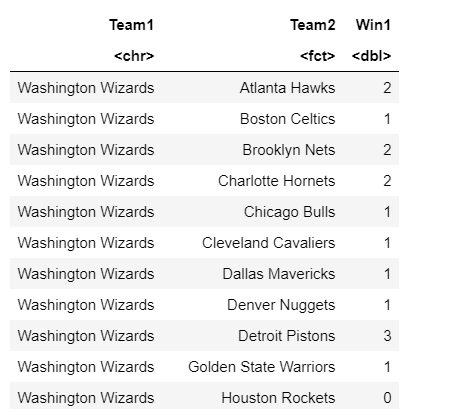

Also note that for the "Account for formatting", this is referring to the table breaks on the data


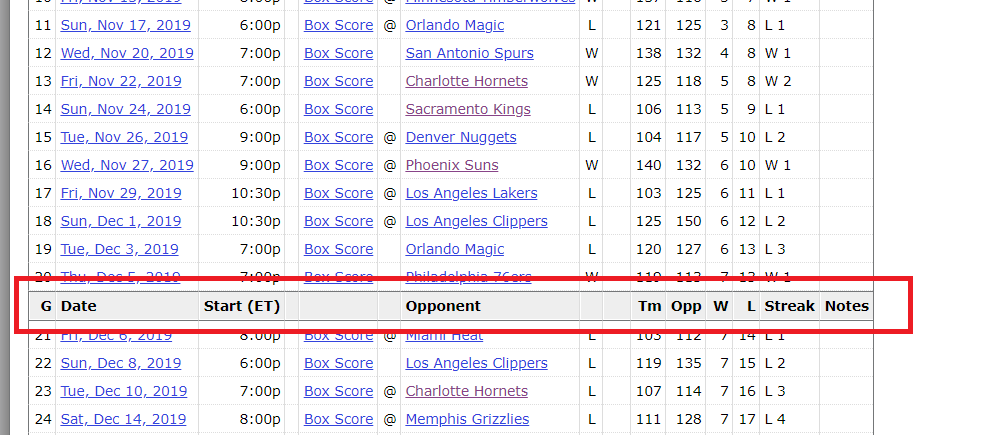

In [ ]:
all_data <- table(NA)
for(team_id in 1:length(teams)) {
  #Pull Schedule & Results table data for each NBA team
  #Set up the URL
  url <- paste0("https://www.basketball-reference.com/teams/", teams[team_id], "/2021_games.html")
  webpage <- read_html(url)
  col_names <- webpage %>% 
    html_nodes("table#games > thead > tr > th") %>% 
    html_attr("data-stat") 
  col_names <- c("game_id", col_names)
  dates <- webpage %>% 
    html_nodes("table#games > tbody > tr > th") %>% 
    html_text()
  #Account for formatting
  dates <- dates[!is.na(dates)]
  game_id <- webpage %>% 
    html_nodes("table#games > tbody > tr > th") %>%
    html_attr("csk")
  #Account for formatting
  game_id <- game_id[!is.na(game_id)]
  #Pull Data
  data <- webpage %>% 
    html_nodes("table#games > tbody > tr > td") %>% 
    html_text() %>%
    matrix(ncol = length(col_names) - 2, byrow = TRUE)
  data <- data.frame(data)
  names(data)[6:7] <- c('Team2', 'Win1')
  #Create Team2 column, recode wins and losses
  data$Win1 = recode(data$Win1, 'W' = 1, 'L' = 0)
  data <- select(data, Team2, Win1)
  data$Team1 <- team_name[team_id]
  data <- setcolorder(data, c('Team1', 'Team2', 'Win1'))
  new <- aggregate(Win1 ~ Team2, data = data, sum)
  new$Team1 <- team_name[team_id]
  #print(team_name[team_id])
  data <- setcolorder(new, c('Team1', 'Team2', 'Win1'))
  all_data <- rbind(all_data, data)
}
all_data[is.na(all_data)] <- 0

The next step is to fill in the wins and losses column, which we will do using the for loop below.

What this loop does is a team from the Team1 column finds a match in the Team2 column, then it takes the number of wins that matched Team2 column and sets it as losses back in the original Team1 row.

For example, when calculating the Atlanta Hawks losses vs. the Boston Celtics:

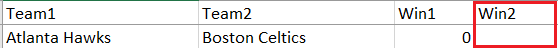

The loop will take us to this row:
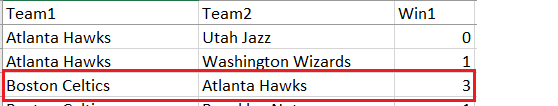

Since the amount of times the Boston Celtics have won against the Atlanta Hawks is the same number of losses the Hawks have had to the Celtics, we can take the 3 losses and put them into the Win2 column for the original row

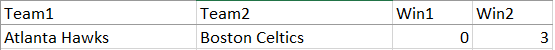

-Don't worry about those losses Hawks fans, you got a great young core ;)

In [ ]:
all_data$Win2 <- NA
delete <- data.frame(NA)

for(j in 1:NROW(all_data)) {
  for (i in 1:NROW(all_data)) {
    if(all_data[j, 1] == all_data[i, 2] & all_data[j, 2] == all_data[i, 1]) {all_data[j, 4] = all_data[i, 3]; delete <- rbind(delete, c(i))}
  }
}

all_data$Team2 <- as.character(all_data$Team2)

Unfortunately, since the NBA season was shortened there are some missing matchups, or in other words some teams never got the chance to play other teams. When looking through the data, the following matchups never occured this season:
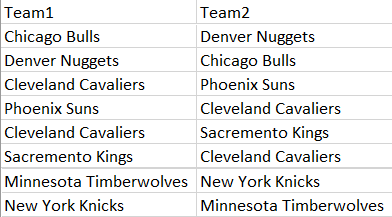

However, we need these matchups in order to complete the model, so in this case we fill in predicted outcomes for these matchups (basically guess who would have won these matchups). I did this based off the most recent NBA power rankings and came up with the following outcomes:


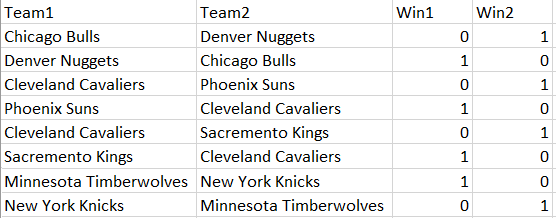

Now, we create a data frame based off these predicted outcomes.

The final step to create the model - here we convert the Team1 and Team2 columns to factors (which is required by the model) and then create the Bradley Terry Model.

In [ ]:
all_data <- all_data[order(all_data$Team2),]
all_data <- all_data[order(all_data$Team1),]
all_data$Team1 <- factor(all_data$Team1) #run these first
all_data$Team2 <- factor(all_data$Team2)

model <- BTm(outcome = cbind(Win1, Win2), player1 = Team1, player2 = Team2, formula = ~Team, id = 'Team', data = all_data)
summary(model)

For the model: 
Each coefficient represents each team’s “ability” and can be used to calculate the probability of outcomes of games between teams. 

For example:
* The Boston Celtics have an “ability” coefficient of -0.263891175842741  and the Brooklyn Nets have a coefficient of 0.42591037792927 
* Thus the odds of the Boston Celtics beating the Brooklyn Nets is (e^-0.263891175842741/(e^-0.263891175842741 + e^0.42591037792927) = 0.33407722005, or about 33%.

Here, we organize the coefficients by team into a data frame, which we will use to pull in the following step.

In [ ]:
Model_Results <- data.frame(coef(model))
Model_Results <- data.frame("Teams" = rownames(Model_Results), "Estimate" = Model_Results$coef.model.)
Model_Results$Teams <- substring(as.character(Model_Results$Teams), 5)
Model_Results$Estimate <- as.numeric(Model_Results$Estimate)
Model_Results <- rbind(Model_Results, data.frame(Teams = 'Atlanta Hawks', Estimate =  0)) #Hawks are the reference team, so they're value is median of model as stated in model summary above

Finally, we've gotten to the fun stuff! Now, what we do here is choose the two teams, and simulate 7 game series.

For this, I am running 10000 simulations of a playoff series between two given teams to determine the predicted result.

For example, when setting **Team_1 = 'Philadelphia 76ers'** and **Team_2 = 'New York Knicks'** below, the result will be something like:

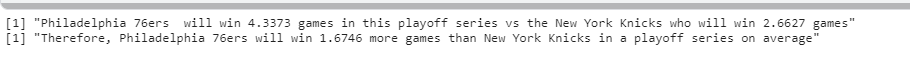

Since the 76ers are predicted to win 2 games more on average, I conclude that the 76ers will win the series 4-2.

In [ ]:
#Simulate playoffs
#Choose Team:
Team_1 = 'Los Angeles Clippers'
Team_2 = 'Utah Jazz'


#Calculate odds of Team1 beating Team2 is (Team1/Team2)/(Team1/Team2 + 1)
Team_1_Odds <- Model_Results[match(Team_1, Model_Results[, 1]),][2]
Team_2_Odds <- Model_Results[match(Team_2, Model_Results[, 1]),][2]
Team_1_Beat_Team_2_Odds <- as.numeric(exp(Team_1_Odds)/(exp(Team_1_Odds) + exp(Team_2_Odds)))

#Simulate 10,000 playoff series
Team_1_Average_Wins = 0
Team_2_Average_Wins = 0
for_loop_runs = 0
for (i in 1:10000){
    proj <- NULL
    for (i in 1:1){
      proj <- cbind(proj, rbinom(7,1,Team_1_Beat_Team_2_Odds))
      #print(rbinom(7,1,Team_1_Beat_Team_2_Odds))
    }

    Games <- c('Game 1', 'Game 2', 'Game 3', 'Game 4', 'Game 5', 'Game 6', 'Game 7')
    Projections <- data.frame(Games, rowMeans(proj))
    Projections$Result <- NA
    for (i in 1:nrow(proj)) {
        if (mean(proj[i,]) > 0.5) {Projections[i,3] <- paste(Team_1, ' Win')} else {Projections[i,3] <- paste(Team_2, ' Win')}
    }
    colnames(Projections) <- c('Games', 'Team_1_Wins', 'Result')
    Team_1_Average_Wins = sum(Projections$Team_1_Wins) + Team_1_Average_Wins
    Team_2_Average_Wins = 7 - sum(Projections$Team_1_Wins) + Team_2_Average_Wins
    for_loop_runs = for_loop_runs + 1
}



print(paste(Team_1, ' will win', Team_1_Average_Wins/for_loop_runs, 'games in this playoff series vs the', Team_2, 'who will win', Team_2_Average_Wins/for_loop_runs, 'games'))
print(paste('Therefore,', Team_1, 'will win', Team_1_Average_Wins/for_loop_runs - Team_2_Average_Wins/for_loop_runs, 'more games than', Team_2, 'in a playoff series on average'))

From using this approach, I came up with the following results:
(note for these results, I didn't rely completely on the model. For teams like Brooklyn or Denver that have had injury complications, I accounted for that when deciding final results)
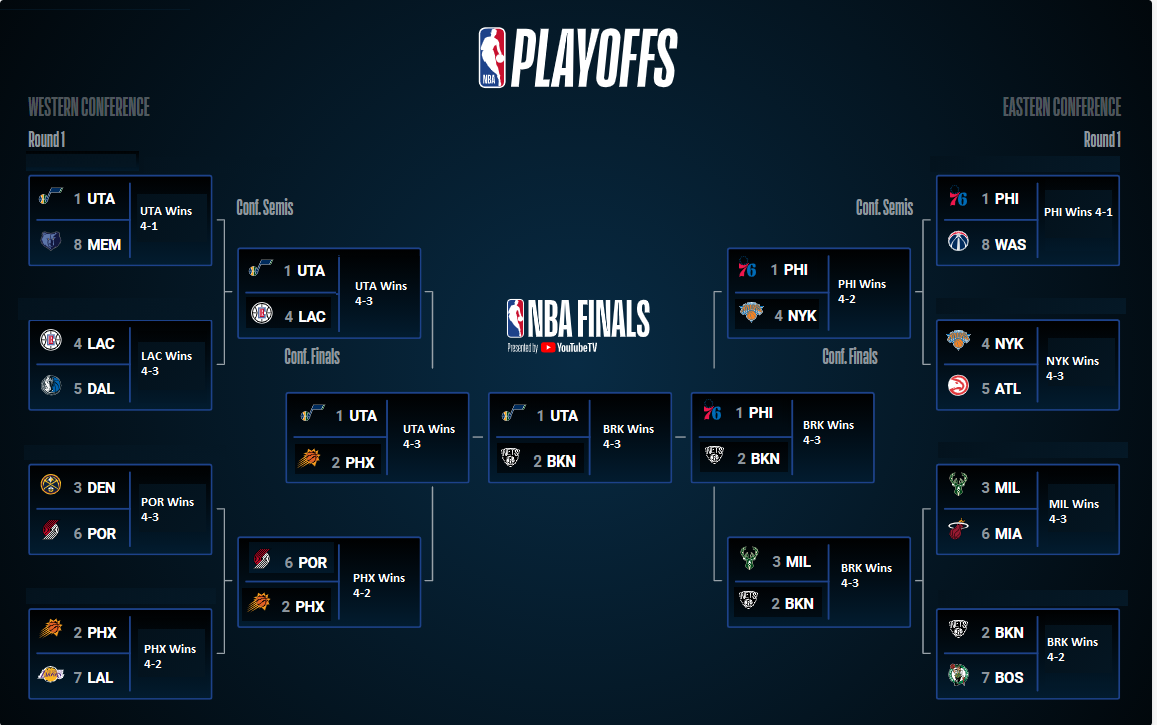

Thanks for reading this, personally I'm a huge NBA fan so creating this model was a blast and I'm really happy to share this!